# Energy-Aware Quantization Measurement Harness
## ESE 5390 Final Project: Accurate Energy Measurement for Quantized LLMs

This notebook implements a zero-I/O measurement harness for measuring:
- **Energy consumption** (per inference)
- **Latency** (per sample and per batch)
- **Throughput** (samples/second)
- **Accuracy** (classification accuracy)
- **Memory usage** (GPU memory)

Across three precision levels:
- **FP32**: Full precision baseline
- **FP16**: Half precision
- **INT8**: 8-bit quantized (simulated on GPU)

In [1]:
!git clone https://github.com/krishkc5/energy_aware_quantization.git

fatal: destination path 'energy_aware_quantization' already exists and is not an empty directory.


## 1. Setup and Imports

In [2]:
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification
import numpy as np
import pandas as pd
import json
import time
import subprocess
import threading
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB
CUDA version: 12.4


## 2. Dataset Loading (Zero-I/O Design)

Load pre-tokenized tensors directly to GPU before any measurements.

In [3]:
def load_pretokenized_dataset(dataset_path: str, device: str = "cuda") -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, Dict]:
    """
    Load pre-tokenized dataset from separate .pt files.
    
    Args:
        dataset_path: Path to directory containing input_ids.pt, attention_mask.pt, labels.pt, metadata.json
        device: Device to load tensors to ('cuda' or 'cpu')
    
    Returns:
        input_ids: [N, seq_len] tensor on device
        attention_mask: [N, seq_len] tensor on device
        labels: [N] tensor on device
        metadata: Dictionary with dataset info
    """
    dataset_path = Path(dataset_path)
    print(f"\nLoading dataset from: {dataset_path}")
    
    # Load tensors
    input_ids = torch.load(dataset_path / "input_ids.pt", map_location=device)
    attention_mask = torch.load(dataset_path / "attention_mask.pt", map_location=device)
    labels = torch.load(dataset_path / "labels.pt", map_location=device)
    
    # Load metadata
    with open(dataset_path / "metadata.json", 'r') as f:
        metadata = json.load(f)
    
    print(f"✓ Loaded {input_ids.shape[0]} samples")
    print(f"  - Sequence length: {input_ids.shape[1]}")
    print(f"  - Device: {input_ids.device}")
    print(f"  - Dataset: {metadata.get('dataset_name', 'unknown')}")
    print(f"  - Labels: {metadata.get('num_labels', 2)}")
    
    # Calculate memory footprint
    total_bytes = (input_ids.element_size() * input_ids.nelement() + 
                   attention_mask.element_size() * attention_mask.nelement() + 
                   labels.element_size() * labels.nelement())
    print(f"  - Memory: {total_bytes / 1024**2:.2f} MB")
    
    return input_ids, attention_mask, labels, metadata

## 3. Model Loading with Accurate Quantization

Load models in FP32, FP16, or INT8 precision.

In [ ]:
class QuantDistilBertWrapper(nn.Module):
    """
    Wrap a DistilBERT classification model with Quant/DeQuant stubs
    so we can use static PTQ (prepare/convert) like in Lab 3.
    """
    def __init__(self, base_model: nn.Module):
        super().__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        self.model = base_model  # usually AutoModelForSequenceClassification

    def forward(self, input_ids, attention_mask=None, **kwargs):
        """
        Quantization-aware forward that stays compatible with the
        HuggingFace output shape expected elsewhere in the project.
        """
        # Quantize token IDs before embedding lookup
        x = self.quant(input_ids)

        # Use DistilBERT embeddings on the quantized IDs, then run the model
        embeddings = self.model.distilbert.embeddings(x)
        outputs = self.model(
            inputs_embeds=embeddings,
            attention_mask=attention_mask,
            **kwargs,
        )

        # Dequantize logits before returning
        logits = self.dequant(outputs.logits)

        # Return an object with `.logits` so existing code keeps working
        class OutputWrapper:
            def __init__(self, logits_tensor):
                self.logits = logits_tensor

        return OutputWrapper(logits)

@dataclass
class ModelConfig:
    """Configuration for model loading."""
    model_name: str
    precision: str  # "fp32", "fp16", "int8"
    device: str = "cuda"
    num_labels: int = 2

@dataclass
class LayerwiseQuantConfig:
    """
    Configuration for hybrid precision per layer.

    `layer_precision` maps a substring (matching module names) to a
    desired precision: "fp32", "fp16", or "int8".
      - "int8"  -> attach qconfig so the module is statically quantized
      - "fp32"/"fp16" -> clear qconfig so the module stays in float

    Example:
        LayerwiseQuantConfig(
            layer_precision={
                "attention": "int8",
                "ffn": "int8",
                "classifier": "fp32",
            }
        )
    """

    layer_precision: Dict[str, str]
    
def apply_layerwise_qconfig(
    model: nn.Module,
    qconfig: torch.ao.quantization.QConfig,
    cfg: LayerwiseQuantConfig,
) -> None:
    """
    Attach qconfig selectively to DistilBERT submodules.

    This is a simple heuristic based on layer-name substrings. It lets
    you implement hybrid schemes (e.g., INT8 attention + FP32 classifier).
    """
    for name, module in model.named_modules():
        # Skip explicit quant/dequant stubs themselves
        if isinstance(module, (QuantStub, DeQuantStub)):
            continue

        matched_precision: Optional[str] = None
        for pattern, prec in cfg.layer_precision.items():
            if pattern in name:
                matched_precision = prec

        if matched_precision is None:
            # No explicit rule -> leave whatever global qconfig is set
            continue

        if matched_precision.lower() == "int8":
            module.qconfig = qconfig
        else:
            # Any non-int8 precision means "keep this layer in float"
            module.qconfig = None




def _apply_int8_quantization_cuda(model: nn.Module, verbose: bool = True) -> None:
    """
    Apply INT8-like quantization for CUDA by quantizing weights to INT8 range.

    This uses symmetric per-tensor quantization:
    - Quantize: Q = round(R / scale) where scale = max(abs(R)) / 127
    - Dequantize: R' = Q * scale

    The weights are stored as FP32/FP16 but quantized to INT8 precision.
    This is not true INT8 compute (which requires special kernels) but
    simulates the accuracy/precision loss of INT8 quantization.

    Args:
        model: Model to quantize (must be on CUDA)
        verbose: Whether to print quantization info
    """
    num_quantized = 0

    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            # Quantize weight
            with torch.no_grad():
                weight = module.weight.data

                # Symmetric per-tensor quantization
                # Scale = max_abs_value / 127 (INT8 max positive value)
                scale = weight.abs().max() / 127.0

                if scale > 0:
                    # Quantize: divide by scale, round, clamp to INT8 range
                    weight_q = torch.round(weight / scale)
                    weight_q = torch.clamp(weight_q, -128, 127)

                    # Dequantize: multiply back by scale
                    weight_dequant = weight_q * scale

                    # Replace original weight with quantized version
                    module.weight.data = weight_dequant

                # Quantize bias if it exists
                if module.bias is not None:
                    bias = module.bias.data
                    scale_bias = bias.abs().max() / 127.0

                    if scale_bias > 0:
                        bias_q = torch.round(bias / scale_bias)
                        bias_q = torch.clamp(bias_q, -128, 127)
                        bias_dequant = bias_q * scale_bias
                        module.bias.data = bias_dequant

                num_quantized += 1

    if verbose:
        print(f"  ✓ Quantized {num_quantized} Linear layers to INT8 precision")
        print(f"  ✓ Running on CUDA (simulated INT8 compute)")


def load_model(
    model_name: str = "distilbert-base-uncased-finetuned-sst-2-english",
    precision: str = "fp32",
    device: str = "cuda",
    num_labels: int = 2,
    verbose: bool = True,
    layerwise_cfg: Optional[LayerwiseQuantConfig] = None,
) -> nn.Module:
    """
    Load a transformer model in specified precision.

    Supports three precision modes:
    - fp32: Full precision (32-bit floating point)
    - fp16: Half precision (16-bit floating point)
    - int8: 8-bit integer quantization (dynamic quantization)

    Args:
        model_name: HuggingFace model name or path
        precision: One of "fp32", "fp16", "int8"
        device: Device to load model to
        num_labels: Number of classification labels
        verbose: Whether to print loading information

    Returns:
        Loaded model in eval mode

    Raises:
        ValueError: If precision mode is invalid

    Example:
        >>> model = load_model("distilbert-base-uncased-finetuned-sst-2-english", "fp16")
        >>> model.eval()
    """
    precision = precision.lower()
    valid_precisions = ["fp32", "fp16", "int8"]

    if precision not in valid_precisions:
        raise ValueError(f"Invalid precision: {precision}. Must be one of {valid_precisions}")

    if device == "cuda" and not torch.cuda.is_available():
        raise ValueError("CUDA requested but not available")

    if verbose:
        print(f"\nLoading model: {model_name}")
        print(f"Precision: {precision}")
        print(f"Device: {device}")

    # Load model configuration
    config = AutoConfig.from_pretrained(model_name)
    config.num_labels = num_labels

    # Load model in FP32 first
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config,
        torch_dtype=torch.float32
    )

    # Apply precision conversion
    if precision == "fp32":
        model = model.to(device)

    elif precision == "fp16":
        # Convert to FP16
        model = model.half()
        model = model.to(device)

    elif precision == "int8":
        # Two paths for INT8:
        #   - CUDA: keep the existing "simulated INT8" path to stay
        #           compatible with the original project harness.
        #   - CPU:  use static PTQ with QuantDistilBertWrapper, qconfig,
        #           prepare + calibration + convert (like Lab 3).
        if device == "cuda":
            if verbose:
                print("  Using CUDA-compatible INT8 (simulated quantization)")

            # Move model to CUDA first
            model = model.to(device)

            # Apply simulated INT8 quantization to Linear layers
            _apply_int8_quantization_cuda(model, verbose=verbose)
        else:
            # Static PTQ on CPU using wrapper + qconfig + prepare/convert
            if verbose:
                print("  Using CPU static PTQ with QuantDistilBertWrapper")

            # Wrap the HF model with Quant/DeQuant stubs
            wrapped = QuantDistilBertWrapper(model)

            # Default to a global qconfig if none is provided
            qconfig = torch.ao.quantization.get_default_qconfig("fbgemm")

            if layerwise_cfg is not None:
                # Attach qconfig selectively to attention / FFN / classifier
                apply_layerwise_qconfig(wrapped, qconfig, layerwise_cfg)
            else:
                # Global qconfig (all eligible modules)
                wrapped.qconfig = qconfig

            if verbose:
                print("  Preparing model for static quantization...")

            prepared = torch.ao.quantization.prepare(wrapped, inplace=False)
            prepared.eval()

            # Lightweight calibration with random token IDs.
            # This is intentionally simple; the main project harness
            # still uses the high-quality FP32/FP16 paths on GPU.
            vocab_size = getattr(config, "vocab_size", 30522)
            seq_len = getattr(config, "max_position_embeddings", 128)

            with torch.no_grad():
                for _ in range(10):
                    dummy_ids = torch.randint(
                        low=0,
                        high=vocab_size,
                        size=(8, seq_len),
                        dtype=torch.long,
                    )
                    dummy_mask = torch.ones_like(dummy_ids)
                    _ = prepared(input_ids=dummy_ids, attention_mask=dummy_mask)

            if verbose:
                print("  Converting calibrated model to INT8...")

            quantized = torch.ao.quantization.convert(prepared, inplace=False)
            model = quantized.to("cpu")

    model.eval()

    if verbose:
        print(f"✓ Model loaded successfully")
        print(f"  - Parameters: {count_parameters(model):,}")
        print(f"  - Model size: {get_model_size_mb(model):.2f} MB")

        # Check actual dtype of first parameter
        first_param = next(model.parameters())
        print(f"  - Parameter dtype: {first_param.dtype}")
        print(f"  - Parameter device: {first_param.device}")

    return model



def load_model_with_autocast(
    model_name: str = "distilbert-base-uncased-finetuned-sst-2-english",
    device: str = "cuda",
    num_labels: int = 2,
    verbose: bool = True
) -> Tuple[nn.Module, torch.autocast]:
    """
    Load FP32 model with autocast context for FP16 inference.

    This approach keeps model weights in FP32 but performs operations in FP16
    using PyTorch's automatic mixed precision.

    Args:
        model_name: HuggingFace model name
        device: Device to load to
        num_labels: Number of labels
        verbose: Whether to print info

    Returns:
        Tuple of (model, autocast_context)

    Example:
        >>> model, autocast_ctx = load_model_with_autocast()
        >>> with autocast_ctx:
        ...     output = model(input_ids, attention_mask)
    """
    if verbose:
        print(f"\nLoading model with autocast: {model_name}")

    config = AutoConfig.from_pretrained(model_name)
    config.num_labels = num_labels

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config
    )
    model = model.to(device)
    model.eval()

    # Create autocast context
    autocast_ctx = torch.autocast(device_type=device, dtype=torch.float16)

    if verbose:
        print(f"Model loaded with autocast")
        print(f"  - Autocast device: {device}")
        print(f"  - Autocast dtype: torch.float16")

    return model, autocast_ctx


def count_parameters(model: nn.Module) -> int:
    """
    Count total number of parameters in model.

    Args:
        model: PyTorch model

    Returns:
        Total parameter count
    """
    return sum(p.numel() for p in model.parameters())


def get_model_size_mb(model: nn.Module) -> float:
    """
    Get model size in megabytes.

    Args:
        model: PyTorch model

    Returns:
        Model size in MB
    """
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_mb = (param_size + buffer_size) / 1024 / 1024
    return size_mb


def get_model_info(model: nn.Module) -> dict:
    """
    Get detailed model information.

    Args:
        model: PyTorch model

    Returns:
        Dictionary with model information
    """
    first_param = next(model.parameters())

    return {
        "num_parameters": count_parameters(model),
        "model_size_mb": get_model_size_mb(model),
        "dtype": str(first_param.dtype),
        "device": str(first_param.device),
        "is_quantized": hasattr(model, "qconfig"),
    }


def validate_model(
    model: nn.Module,
    input_ids: torch.Tensor,
    attention_mask: torch.Tensor,
    expected_device: str = "cuda"
) -> bool:
    """
    Validate that model is properly loaded and can perform inference.

    Args:
        model: Model to validate
        input_ids: Sample input IDs
        attention_mask: Sample attention mask
        expected_device: Expected device for model

    Returns:
        True if validation passes

    Raises:
        RuntimeError: If validation fails
    """
    # Check model is in eval mode
    if model.training:
        raise RuntimeError("Model is in training mode, should be in eval mode")

    # Check device
    model_device = next(model.parameters()).device
    if expected_device not in str(model_device):
        raise RuntimeError(
            f"Model on wrong device: expected {expected_device}, got {model_device}"
        )

    # Check inputs are on same device as model
    if str(input_ids.device) != str(model_device):
        raise RuntimeError(
            f"Input device mismatch: inputs on {input_ids.device}, model on {model_device}"
        )

    # Try a forward pass
    try:
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        # Check output shape
        if logits.shape[0] != input_ids.shape[0]:
            raise RuntimeError(
                f"Output batch size mismatch: {logits.shape[0]} != {input_ids.shape[0]}"
            )

    except Exception as e:
        raise RuntimeError(f"Forward pass failed: {e}")

    print(f"✓ Model validation passed")
    return True


# Preset model configurations
PRESET_MODELS = {
    "distilbert-sst2": "distilbert-base-uncased-finetuned-sst-2-english",
    "distilbert": "distilbert-base-uncased",
    "gpt2-small": "gpt2",
}


def get_preset_model_name(preset: str) -> str:
    """
    Get full model name from preset.

    Args:
        preset: Preset name (e.g., "distilbert-sst2")

    Returns:
        Full HuggingFace model name

    Raises:
        ValueError: If preset is not found
    """
    if preset in PRESET_MODELS:
        return PRESET_MODELS[preset]

    # If not a preset, assume it's already a full model name
    return preset


## 4. GPU Warmup

Stabilize GPU clocks and compile CUDA kernels before measurement.

In [5]:
def warmup_gpu(model: nn.Module, input_ids: torch.Tensor, attention_mask: torch.Tensor, 
               num_steps: int = 50, verbose: bool = True) -> None:
    """
    Warmup GPU to stabilize clocks and compile kernels.
    
    Args:
        model: Model to warmup
        input_ids: Sample input tensor
        attention_mask: Sample attention mask
        num_steps: Number of warmup iterations
        verbose: Print progress
    """
    if verbose:
        print(f"\nWarming up GPU for {num_steps} iterations...")
    
    model.eval()
    
    with torch.no_grad():
        for i in range(num_steps):
            _ = model(input_ids=input_ids, attention_mask=attention_mask)
            
            if verbose and (i + 1) % 10 == 0:
                print(f"  Warmup: {i+1}/{num_steps}", end='\r')
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    if verbose:
        print(f"\n  ✓ Warmup complete")

## 5. Power Logger (Asynchronous)

Monitor GPU power draw using nvidia-smi without interfering with timing.

In [6]:
class PowerLogger:
    """
    Asynchronous power logger using nvidia-smi polling.
    """
    
    def __init__(self, sample_interval_ms: int = 100, gpu_id: int = 0, verbose: bool = False):
        self.sample_interval_ms = sample_interval_ms
        self.gpu_id = gpu_id
        self.verbose = verbose
        self.samples = []
        self.is_running = False
        self._lock = threading.Lock()
        self._reader_thread = None
        
        # Verify nvidia-smi is available
        self._check_nvidia_smi()
    
    def _check_nvidia_smi(self) -> None:
        """Check if nvidia-smi is available."""
        try:
            result = subprocess.run(
                ["nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits", f"--id={self.gpu_id}"],
                capture_output=True, text=True, timeout=5
            )
            if result.returncode != 0:
                raise RuntimeError(f"nvidia-smi failed: {result.stderr}")
            power = float(result.stdout.strip())
            if self.verbose:
                print(f"  ✓ nvidia-smi available, current power: {power:.2f} W")
        except Exception as e:
            raise RuntimeError(f"nvidia-smi not available: {e}")
    
    def start(self) -> None:
        """Start power logging in background thread."""
        with self._lock:
            if self.is_running:
                raise RuntimeError("PowerLogger already running")
            self.samples = []
            self.is_running = True
        
        self._reader_thread = threading.Thread(target=self._poll_power, daemon=True)
        self._reader_thread.start()
        
        if self.verbose:
            print(f"  ✓ Power logger started (interval: {self.sample_interval_ms} ms)")
    
    def _poll_power(self) -> None:
        """Background thread that polls nvidia-smi."""
        interval_sec = self.sample_interval_ms / 1000.0
        
        while self.is_running:
            try:
                result = subprocess.run(
                    ["nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits", f"--id={self.gpu_id}"],
                    capture_output=True, text=True, timeout=2
                )
                
                if result.returncode == 0:
                    power = float(result.stdout.strip())
                    with self._lock:
                        self.samples.append(power)
            except:
                pass
            
            time.sleep(interval_sec)
    
    def stop(self) -> None:
        """Stop power logging."""
        with self._lock:
            if not self.is_running:
                raise RuntimeError("PowerLogger not running")
            self.is_running = False
        
        if self._reader_thread:
            self._reader_thread.join(timeout=2)
        
        if self.verbose:
            print(f"  ✓ Power logger stopped ({len(self.samples)} samples)")
    
    def get_samples(self) -> List[float]:
        """Return collected power samples."""
        with self._lock:
            return self.samples.copy()
    
    def __enter__(self):
        self.start()
        return self
    
    def __exit__(self, *args):
        if self.is_running:
            self.stop()

## 6. Timed Inference Benchmark

Run inference with precise timing and CUDA synchronization.

In [7]:
def run_timed_inference(model: nn.Module, input_ids: torch.Tensor, attention_mask: torch.Tensor,
                       num_iters: int, verbose: bool = True) -> Dict:
    """
    Run timed inference loop with CUDA synchronization.
    
    Args:
        model: Model in eval mode
        input_ids: Input tensor [batch_size, seq_len]
        attention_mask: Attention mask [batch_size, seq_len]
        num_iters: Number of iterations
        verbose: Print progress
    
    Returns:
        Dictionary with timing metrics
    """
    if verbose:
        print(f"\nRunning {num_iters} timed inference iterations...")
    
    model.eval()
    batch_size = input_ids.shape[0]
    latencies = []
    
    # Ensure clean state
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    start_time = time.perf_counter()
    
    with torch.no_grad():
        for i in range(num_iters):
            iter_start = time.perf_counter()
            
            # Forward pass
            _ = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Synchronize to ensure completion
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            
            iter_end = time.perf_counter()
            latencies.append(iter_end - iter_start)
            
            if verbose and (i + 1) % 50 == 0:
                print(f"  Progress: {i+1}/{num_iters}", end='\r')
    
    end_time = time.perf_counter()
    total_time = end_time - start_time
    
    if verbose:
        print(f"\n  ✓ Inference complete: {total_time:.3f}s")
    
    latencies = np.array(latencies)
    
    return {
        "total_time": float(total_time),
        "num_iters": num_iters,
        "batch_size": batch_size,
        "mean_latency": float(np.mean(latencies)),
        "std_latency": float(np.std(latencies)),
        "min_latency": float(np.min(latencies)),
        "max_latency": float(np.max(latencies)),
        "median_latency": float(np.median(latencies)),
        "throughput": float(batch_size * num_iters / total_time)
    }


def compute_accuracy(model: nn.Module, input_ids: torch.Tensor, attention_mask: torch.Tensor,
                    labels: torch.Tensor, verbose: bool = True) -> Dict:
    """
    Compute model accuracy on dataset.
    
    Returns:
        Dictionary with accuracy metrics
    """
    if verbose:
        print(f"\nComputing accuracy...")
    
    model.eval()
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct = (predictions == labels).sum().item()
        total = labels.shape[0]
        accuracy = correct / total
    
    if verbose:
        print(f"  ✓ Accuracy: {accuracy*100:.2f}% ({correct}/{total})")
    
    return {
        "accuracy": float(accuracy),
        "num_correct": int(correct),
        "num_samples": int(total)
    }

## 7. Energy Computation

Compute energy metrics from power samples and timing.

In [8]:
def compute_energy_metrics(power_samples: List[float], timing_results: Dict) -> Dict:
    """
    Compute energy consumption from power samples and timing.
    
    Energy (J) = Power (W) × Time (s)
    
    IMPORTANT: This computes energy PER SAMPLE, not per batch iteration.
    - Each iteration processes batch_size samples
    - Energy per sample = Total energy / (num_iters × batch_size)
    
    Args:
        power_samples: List of power measurements in Watts
        timing_results: Dictionary from run_timed_inference
    
    Returns:
        Dictionary with energy metrics
    """
    if len(power_samples) == 0:
        print("  ⚠️  Warning: No power samples collected")
        return {
            "mean_power_w": None,
            "std_power_w": None,
            "min_power_w": None,
            "max_power_w": None,
            "num_power_samples": 0,
            "total_energy_j": None,
            "energy_per_batch_j": None,
            "energy_per_batch_mj": None,
            "energy_per_sample_j": None,
            "energy_per_sample_mj": None,
            "samples_per_joule": None
        }
    
    power_array = np.array(power_samples)
    
    # Power statistics
    mean_power = float(np.mean(power_array))
    std_power = float(np.std(power_array))
    min_power = float(np.min(power_array))
    max_power = float(np.max(power_array))
    
    # Energy computation
    total_time = timing_results["total_time"]
    num_iters = timing_results["num_iters"]
    batch_size = timing_results["batch_size"]
    total_samples = num_iters * batch_size
    
    # Total energy for all iterations
    total_energy = mean_power * total_time  # Joules
    
    # Energy per batch (per iteration)
    energy_per_batch = total_energy / num_iters
    energy_per_batch_mj = energy_per_batch * 1000  # millijoules
    
    # Energy per sample (correct metric!)
    energy_per_sample = total_energy / total_samples
    energy_per_sample_mj = energy_per_sample * 1000  # millijoules
    
    return {
        "mean_power_w": mean_power,
        "std_power_w": std_power,
        "min_power_w": min_power,
        "max_power_w": max_power,
        "num_power_samples": len(power_samples),
        "total_energy_j": total_energy,
        "total_samples": total_samples,
        # Per-batch metrics (for reference)
        "energy_per_batch_j": energy_per_batch,
        "energy_per_batch_mj": energy_per_batch_mj,
        # Per-sample metrics (the correct ones!)
        "energy_per_sample_j": energy_per_sample,
        "energy_per_sample_mj": energy_per_sample_mj,
        "samples_per_joule": 1.0 / energy_per_sample if energy_per_sample > 0 else None
    }

## 8. Complete Measurement Function

Orchestrate the complete measurement pipeline for one trial.

In [9]:
def run_single_trial(model_name: str, precision: str, input_ids: torch.Tensor, 
                    attention_mask: torch.Tensor, labels: torch.Tensor,
                    num_iters: int = 300, warmup_iters: int = 50, 
                    power_interval_ms: int = 100, device: str = "cuda",
                    trial_num: int = 1, verbose: bool = True) -> Dict:
    """
    Run a complete measurement trial for one precision level.
    
    Pipeline:
    1. Load model
    2. Warmup GPU
    3. Start power logging
    4. Run timed inference
    5. Stop power logging
    6. Compute accuracy
    7. Compute energy metrics
    8. Collect memory stats
    
    Returns:
        Dictionary with all metrics
    """
    print(f"\n{'='*70}")
    print(f"TRIAL {trial_num}: {precision.upper()}")
    print(f"{'='*70}")
    
    # Reset GPU memory
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
    
    # 1. Load model
    model = load_model(model_name, precision, device, num_labels=2, verbose=verbose)
    model_info = get_model_info(model)
    
    # 2. Warmup
    warmup_gpu(model, input_ids, attention_mask, num_steps=warmup_iters, verbose=verbose)
    
    # 3. Start power logging
    print(f"\nStarting measurement...")
    power_logger = PowerLogger(sample_interval_ms=power_interval_ms, verbose=verbose)
    power_logger.start()
    time.sleep(0.5)  # Let logger stabilize
    
    # 4. Run timed inference
    timing_results = run_timed_inference(model, input_ids, attention_mask, num_iters, verbose=verbose)
    
    # 5. Stop power logging
    time.sleep(0.5)  # Capture trailing samples
    power_logger.stop()
    power_samples = power_logger.get_samples()
    
    # 6. Compute accuracy
    accuracy_results = compute_accuracy(model, input_ids, attention_mask, labels, verbose=verbose)
    
    # 7. Compute energy
    energy_results = compute_energy_metrics(power_samples, timing_results)
    
    # 8. Memory stats
    memory_stats = {}
    if torch.cuda.is_available():
        memory_stats = {
            "peak_memory_mb": torch.cuda.max_memory_allocated() / 1024**2,
            "allocated_memory_mb": torch.cuda.memory_allocated() / 1024**2,
            "reserved_memory_mb": torch.cuda.memory_reserved() / 1024**2
        }
    
    # Combine all results
    results = {
        "trial": trial_num,
        "precision": precision,
        "model_name": model_name,
        "timestamp": datetime.now().isoformat(),
    }
    results.update(timing_results)
    results.update(accuracy_results)
    results.update(energy_results)
    results.update(memory_stats)
    results.update(model_info)
    
    # Print summary
    print(f"\n{'='*70}")
    print(f"TRIAL {trial_num} SUMMARY: {precision.upper()}")
    print(f"{'='*70}")
    print(f"Batch size:    {timing_results['batch_size']} samples")
    print(f"Iterations:    {timing_results['num_iters']}")
    print(f"Total samples: {energy_results.get('total_samples', timing_results['batch_size'] * timing_results['num_iters'])}")
    print(f"Latency:       {timing_results['mean_latency']*1000:.3f} ms/batch (± {timing_results['std_latency']*1000:.3f} ms)")
    print(f"Throughput:    {timing_results['throughput']:.2f} samples/s")
    print(f"Accuracy:      {accuracy_results['accuracy']*100:.2f}%")
    if energy_results['mean_power_w'] is not None:
        print(f"Power:         {energy_results['mean_power_w']:.2f} W (± {energy_results['std_power_w']:.2f} W)")
        print(f"Total Energy:  {energy_results['total_energy_j']:.3f} J")
        print(f"Energy/batch:  {energy_results['energy_per_batch_mj']:.3f} mJ")
        print(f"Energy/sample: {energy_results['energy_per_sample_mj']:.3f} mJ  ← (correct per-sample metric)")
    if memory_stats:
        print(f"Peak Memory:   {memory_stats['peak_memory_mb']:.2f} MB")
    print(f"{'='*70}")
    
    # Cleanup
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return results

## 9. Multi-Trial Runner

Run multiple trials for statistical significance.

In [10]:
def run_multi_trial_experiment(model_name: str, precision: str, dataset_path: str,
                              num_trials: int = 5, num_iters: int = 300,
                              warmup_iters: int = 50, power_interval_ms: int = 100,
                              device: str = "cuda") -> Tuple[List[Dict], Dict]:
    """
    Run multiple trials for one precision level and aggregate results.
    
    Returns:
        trial_results: List of per-trial result dictionaries
        aggregated: Dictionary with mean/std across trials
    """
    print(f"\n{'#'*70}")
    print(f"# MULTI-TRIAL EXPERIMENT: {precision.upper()}")
    print(f"# Number of trials: {num_trials}")
    print(f"# Iterations per trial: {num_iters}")
    print(f"{'#'*70}")
    
    # Load dataset once (stays on GPU)
    input_ids, attention_mask, labels, metadata = load_pretokenized_dataset(dataset_path, device)
    
    # Run trials
    trial_results = []
    for trial in range(1, num_trials + 1):
        result = run_single_trial(
            model_name=model_name,
            precision=precision,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            num_iters=num_iters,
            warmup_iters=warmup_iters,
            power_interval_ms=power_interval_ms,
            device=device,
            trial_num=trial,
            verbose=True
        )
        trial_results.append(result)
    
    # Aggregate results
    aggregated = aggregate_trials(trial_results)
    print_aggregated_results(aggregated, precision)
    
    return trial_results, aggregated


def aggregate_trials(trial_results: List[Dict]) -> Dict:
    """Compute mean and std across trials."""
    numeric_keys = [
        "mean_latency", "std_latency", "throughput", "accuracy",
        "mean_power_w", "std_power_w", "total_energy_j", 
        "energy_per_batch_j", "energy_per_batch_mj",
        "energy_per_sample_j", "energy_per_sample_mj",
        "peak_memory_mb"
    ]
    
    aggregated = {
        "precision": trial_results[0]["precision"],
        "model_name": trial_results[0]["model_name"],
        "num_trials": len(trial_results),
        "batch_size": trial_results[0]["batch_size"],
        "total_samples": trial_results[0].get("total_samples", trial_results[0]["batch_size"] * trial_results[0]["num_iters"]),
        "model_size_mb": trial_results[0]["model_size_mb"],
        "num_parameters": trial_results[0]["num_parameters"]
    }
    
    for key in numeric_keys:
        if key in trial_results[0] and trial_results[0][key] is not None:
            values = [r[key] for r in trial_results if key in r and r[key] is not None]
            if values:
                aggregated[f"{key}_mean"] = float(np.mean(values))
                aggregated[f"{key}_std"] = float(np.std(values))
                aggregated[f"{key}_min"] = float(np.min(values))
                aggregated[f"{key}_max"] = float(np.max(values))
    
    return aggregated


def print_aggregated_results(agg: Dict, precision: str) -> None:
    """Pretty print aggregated results."""
    print(f"\n{'='*70}")
    print(f"AGGREGATED RESULTS: {precision.upper()}")
    print(f"Trials: {agg['num_trials']}")
    print(f"Batch size: {agg['batch_size']} samples")
    print(f"Total samples per trial: {agg.get('total_samples', 'N/A')}")
    print(f"{'='*70}")
    
    if 'mean_latency_mean' in agg:
        print(f"\nLatency (per batch):")
        print(f"  {agg['mean_latency_mean']*1000:.3f} ± {agg['mean_latency_std']*1000:.3f} ms")
    
    if 'throughput_mean' in agg:
        print(f"\nThroughput:")
        print(f"  {agg['throughput_mean']:.2f} ± {agg['throughput_std']:.2f} samples/s")
    
    if 'accuracy_mean' in agg:
        print(f"\nAccuracy:")
        print(f"  {agg['accuracy_mean']*100:.2f} ± {agg['accuracy_std']*100:.2f}%")
    
    if 'mean_power_w_mean' in agg:
        print(f"\nPower:")
        print(f"  {agg['mean_power_w_mean']:.2f} ± {agg['mean_power_w_std']:.2f} W")
    
    if 'energy_per_batch_mj_mean' in agg:
        print(f"\nEnergy per Batch:")
        print(f"  {agg['energy_per_batch_mj_mean']:.3f} ± {agg['energy_per_batch_mj_std']:.3f} mJ")
    
    if 'energy_per_sample_mj_mean' in agg:
        print(f"\nEnergy per Sample (CORRECT METRIC):")
        print(f"  {agg['energy_per_sample_mj_mean']:.3f} ± {agg['energy_per_sample_mj_std']:.3f} mJ")
    
    if 'peak_memory_mb_mean' in agg:
        print(f"\nMemory:")
        print(f"  Model size: {agg['model_size_mb']:.2f} MB")
        print(f"  Peak GPU: {agg['peak_memory_mb_mean']:.2f} ± {agg['peak_memory_mb_std']:.2f} MB")
    
    print(f"{'='*70}\n")

## 10. Results Saving

Save results in CSV and JSON formats.

In [11]:
def save_results(trial_results: List[Dict], aggregated: Dict, 
                precision: str, output_dir: str = "./results") -> None:
    """
    Save trial and aggregated results.
    
    Creates:
    - results/{precision}_trials.csv: Per-trial results
    - results/{precision}_aggregated.json: Aggregated statistics
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save detailed trial results
    trials_df = pd.DataFrame(trial_results)
    trials_path = output_dir / f"{precision}_trials.csv"
    trials_df.to_csv(trials_path, index=False)
    print(f"\n✓ Saved trial results: {trials_path}")
    
    # Save aggregated results
    agg_path = output_dir / f"{precision}_aggregated.json"
    with open(agg_path, 'w') as f:
        json.dump(aggregated, f, indent=2)
    print(f"✓ Saved aggregated results: {agg_path}")


def save_comparison_table(all_aggregated: List[Dict], output_dir: str = "./results") -> pd.DataFrame:
    """
    Create and save comparison table across all precisions.
    """
    output_dir = Path(output_dir)
    
    comparison_df = pd.DataFrame(all_aggregated)
    comparison_path = output_dir / "comparison_all_precisions.csv"
    comparison_df.to_csv(comparison_path, index=False)
    print(f"\n✓ Saved comparison table: {comparison_path}")
    
    return comparison_df

## 11. Main Experiment Runner

Run experiments for all precision levels.

In [12]:
# Configuration - Use current working directory to find dataset
import os

# Get current working directory and find dataset
cwd = os.getcwd()
print(f"Current working directory: {cwd}")

# Try multiple paths relative to cwd
possible_paths = [
    Path(cwd) / ".." / "datasets" / "tokenized_data",  # From notebooks/
    Path(cwd) / "datasets" / "tokenized_data",          # From repo root
    Path(cwd) / ".." / ".." / "datasets" / "tokenized_data",  # From deeper nesting
    Path("/kaggle/working/energy_aware_quantization/datasets/tokenized_data"),  # Kaggle path
]

dataset_path = None
for path in possible_paths:
    abs_path = path.resolve()
    print(f"Trying: {abs_path}")
    if abs_path.exists() and (abs_path / "input_ids.pt").exists():
        dataset_path = str(abs_path)
        break

if dataset_path is None:
    # Last resort: search upward from cwd
    current = Path(cwd)
    for _ in range(5):  # Search up to 5 levels up
        test_path = current / "datasets" / "tokenized_data"
        print(f"Trying: {test_path.resolve()}")
        if test_path.exists() and (test_path / "input_ids.pt").exists():
            dataset_path = str(test_path.resolve())
            break
        current = current.parent
    
if dataset_path is None:
    raise FileNotFoundError(
        f"Could not find datasets/tokenized_data directory.\n"
        f"Searched from: {cwd}\n"
        f"Please ensure the dataset exists or update the dataset_path manually."
    )

print(f"✓ Found dataset at: {dataset_path}")

# Set output directory
output_path = Path(cwd) / ".." / "results"
if not output_path.parent.exists():
    output_path = Path(cwd) / "results"
output_dir = str(output_path.resolve())

CONFIG = {
    "model_name": "distilbert-base-uncased-finetuned-sst-2-english",
    "dataset_path": dataset_path,
    "precisions": ["fp32", "fp16", "int8"],  # Precision levels to test
    "num_trials": 5,  # Number of trials per precision
    "num_iters": 300,  # Inference iterations per trial
    "warmup_iters": 50,  # Warmup iterations
    "power_interval_ms": 100,  # Power sampling interval
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "output_dir": output_dir
}

print("\nExperiment Configuration:")
print(json.dumps(CONFIG, indent=2))

Current working directory: /kaggle/working
Trying: /kaggle/datasets/tokenized_data
Trying: /kaggle/working/datasets/tokenized_data
Trying: /datasets/tokenized_data
Trying: /kaggle/working/energy_aware_quantization/datasets/tokenized_data
✓ Found dataset at: /kaggle/working/energy_aware_quantization/datasets/tokenized_data

Experiment Configuration:
{
  "model_name": "distilbert-base-uncased-finetuned-sst-2-english",
  "dataset_path": "/kaggle/working/energy_aware_quantization/datasets/tokenized_data",
  "precisions": [
    "fp32",
    "fp16",
    "int8"
  ],
  "num_trials": 5,
  "num_iters": 300,
  "warmup_iters": 50,
  "power_interval_ms": 100,
  "device": "cuda",
  "output_dir": "/kaggle/results"
}


In [13]:
# Run experiments for all precisions
all_trial_results = {}
all_aggregated = []

for precision in CONFIG["precisions"]:
    trial_results, aggregated = run_multi_trial_experiment(
        model_name=CONFIG["model_name"],
        precision=precision,
        dataset_path=CONFIG["dataset_path"],
        num_trials=CONFIG["num_trials"],
        num_iters=CONFIG["num_iters"],
        warmup_iters=CONFIG["warmup_iters"],
        power_interval_ms=CONFIG["power_interval_ms"],
        device=CONFIG["device"]
    )
    
    # Save results
    save_results(trial_results, aggregated, precision, CONFIG["output_dir"])
    
    # Store for comparison
    all_trial_results[precision] = trial_results
    all_aggregated.append(aggregated)

# Save comparison table
comparison_df = save_comparison_table(all_aggregated, CONFIG["output_dir"])

print("\n" + "#"*70)
print("# ALL EXPERIMENTS COMPLETE")
print("#"*70)


######################################################################
# MULTI-TRIAL EXPERIMENT: FP32
# Number of trials: 5
# Iterations per trial: 300
######################################################################

Loading dataset from: /kaggle/working/energy_aware_quantization/datasets/tokenized_data
✓ Loaded 50 samples
  - Sequence length: 128
  - Device: cuda:0
  - Dataset: sst2
  - Labels: 2
  - Memory: 0.10 MB

TRIAL 1: FP32

Loading model: distilbert-base-uncased-finetuned-sst-2-english
  Precision: FP32
  Device: cuda


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

2025-12-03 10:43:44.262639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764758624.455950      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764758624.514320      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  ✓ Model loaded successfully
  - Parameters: 66,955,010
  - Model size: 255.42 MB
  - Param dtype: torch.float32
  - Param device: cuda:0

Warming up GPU for 50 iterations...
  Warmup: 50/50
  ✓ Warmup complete

Starting measurement...
  ✓ nvidia-smi available, current power: 80.28 W
  ✓ Power logger started (interval: 100 ms)

Running 300 timed inference iterations...
  Progress: 300/300
  ✓ Inference complete: 25.961s
  ✓ Power logger stopped (217 samples)

Computing accuracy...
  ✓ Accuracy: 86.00% (43/50)

TRIAL 1 SUMMARY: FP32
Batch size:    50 samples
Iterations:    300
Total samples: 15000
Latency:       86.534 ms/batch (± 0.483 ms)
Throughput:    577.78 samples/s
Accuracy:      86.00%
Power:         228.78 W (± 38.90 W)
Total Energy:  5939.401 J
Energy/batch:  19798.004 mJ
Energy/sample: 395.960 mJ  ← (correct per-sample metric)
Peak Memory:   476.35 MB

TRIAL 2: FP32

Loading model: distilbert-base-uncased-finetuned-sst-2-english
  Precision: FP32
  Device: cuda
  ✓ Model loa

## 12. Results Analysis and Visualization


✓ Saved plots: /kaggle/results/comparison_plots.png


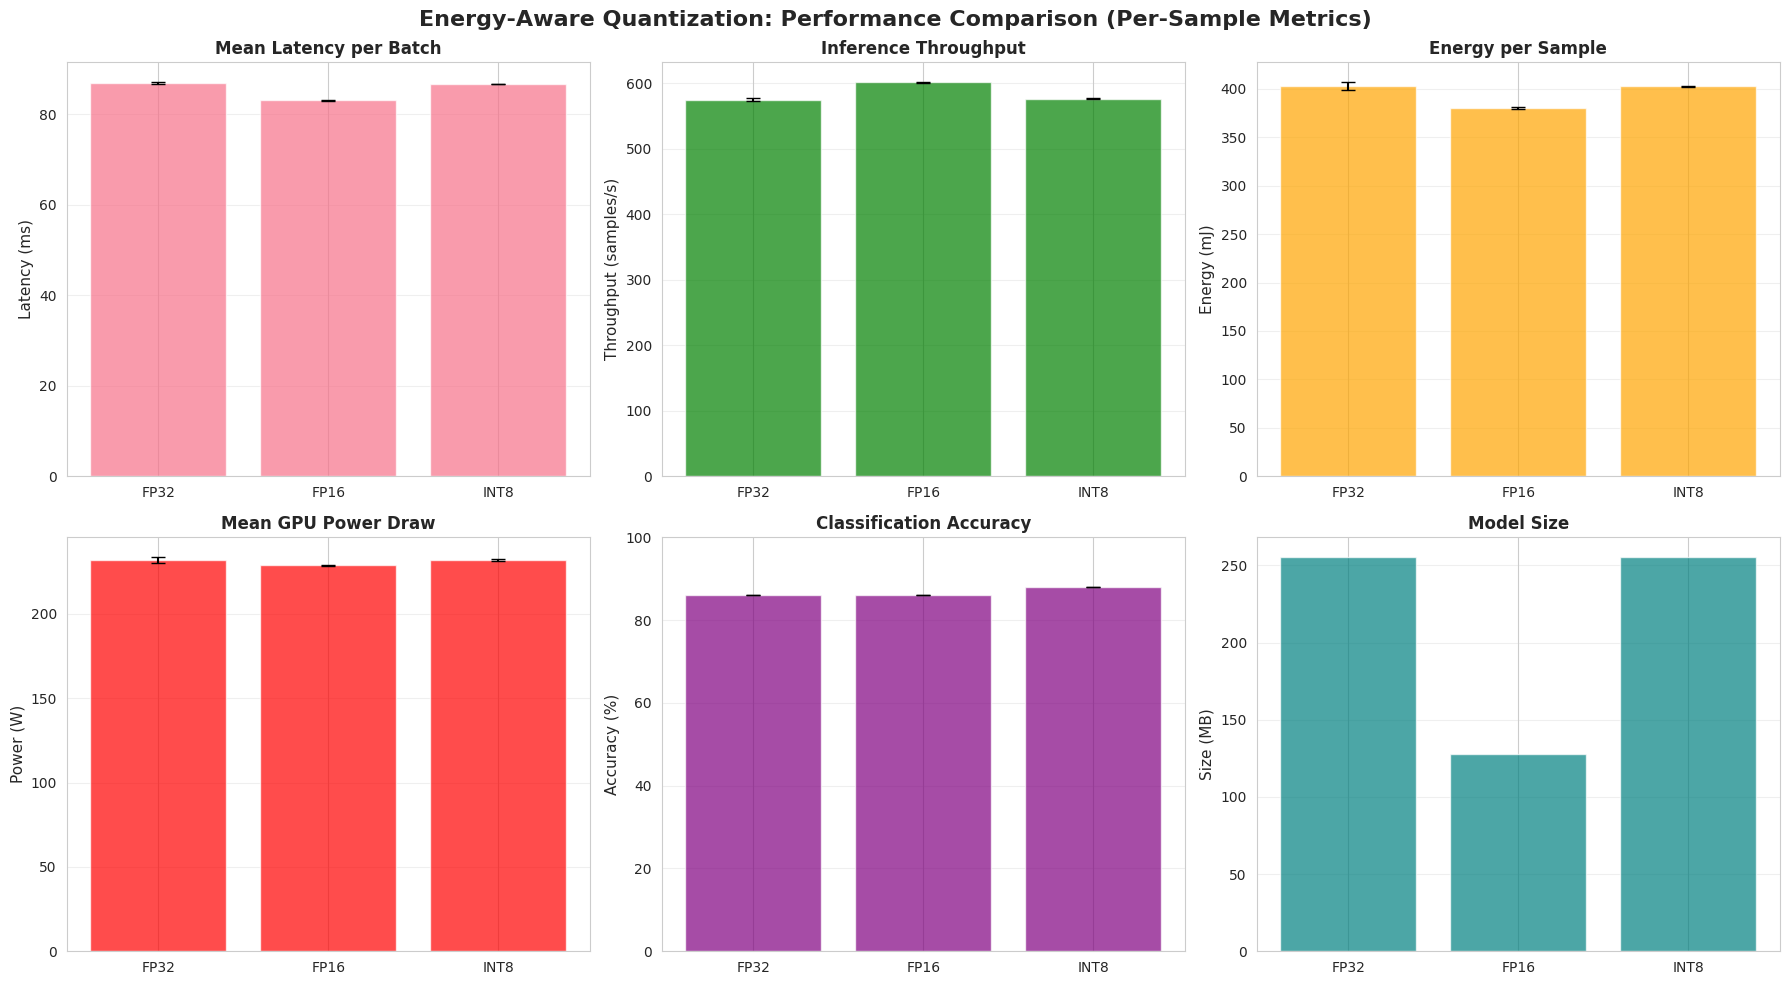

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("husl")

# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Energy-Aware Quantization: Performance Comparison (Per-Sample Metrics)", fontsize=16, fontweight='bold')

df = pd.DataFrame(all_aggregated)

# 1. Latency per batch
ax = axes[0, 0]
if 'mean_latency_mean' in df.columns:
    x = range(len(df))
    ax.bar(x, df['mean_latency_mean']*1000, yerr=df['mean_latency_std']*1000, capsize=5, alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(df['precision'].str.upper())
    ax.set_ylabel('Latency (ms)', fontsize=11)
    ax.set_title('Mean Latency per Batch', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

# 2. Throughput
ax = axes[0, 1]
if 'throughput_mean' in df.columns:
    x = range(len(df))
    ax.bar(x, df['throughput_mean'], yerr=df['throughput_std'], capsize=5, alpha=0.7, color='green')
    ax.set_xticks(x)
    ax.set_xticklabels(df['precision'].str.upper())
    ax.set_ylabel('Throughput (samples/s)', fontsize=11)
    ax.set_title('Inference Throughput', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

# 3. Energy per Sample (CORRECT METRIC)
ax = axes[0, 2]
if 'energy_per_sample_mj_mean' in df.columns:
    x = range(len(df))
    ax.bar(x, df['energy_per_sample_mj_mean'], yerr=df['energy_per_sample_mj_std'], 
           capsize=5, alpha=0.7, color='orange')
    ax.set_xticks(x)
    ax.set_xticklabels(df['precision'].str.upper())
    ax.set_ylabel('Energy (mJ)', fontsize=11)
    ax.set_title('Energy per Sample', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

# 4. Power Draw
ax = axes[1, 0]
if 'mean_power_w_mean' in df.columns:
    x = range(len(df))
    ax.bar(x, df['mean_power_w_mean'], yerr=df['mean_power_w_std'], capsize=5, alpha=0.7, color='red')
    ax.set_xticks(x)
    ax.set_xticklabels(df['precision'].str.upper())
    ax.set_ylabel('Power (W)', fontsize=11)
    ax.set_title('Mean GPU Power Draw', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

# 5. Accuracy
ax = axes[1, 1]
if 'accuracy_mean' in df.columns:
    x = range(len(df))
    ax.bar(x, df['accuracy_mean']*100, yerr=df['accuracy_std']*100, capsize=5, alpha=0.7, color='purple')
    ax.set_xticks(x)
    ax.set_xticklabels(df['precision'].str.upper())
    ax.set_ylabel('Accuracy (%)', fontsize=11)
    ax.set_title('Classification Accuracy', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 100])
    ax.grid(axis='y', alpha=0.3)

# 6. Model Size
ax = axes[1, 2]
if 'model_size_mb' in df.columns:
    x = range(len(df))
    ax.bar(x, df['model_size_mb'], alpha=0.7, color='teal')
    ax.set_xticks(x)
    ax.set_xticklabels(df['precision'].str.upper())
    ax.set_ylabel('Size (MB)', fontsize=11)
    ax.set_title('Model Size', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plot_path = Path(CONFIG["output_dir"]) / "comparison_plots.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved plots: {plot_path}")
plt.show()

## 13. Summary Table

In [15]:
# Create formatted summary table
summary_data = []

for agg in all_aggregated:
    row = {
        "Precision": agg["precision"].upper(),
        "Batch Size": agg.get("batch_size", "N/A"),
        "Latency/batch (ms)": f"{agg.get('mean_latency_mean', 0)*1000:.3f} ± {agg.get('mean_latency_std', 0)*1000:.3f}",
        "Throughput (samples/s)": f"{agg.get('throughput_mean', 0):.2f} ± {agg.get('throughput_std', 0):.2f}",
        "Accuracy (%)": f"{agg.get('accuracy_mean', 0)*100:.2f} ± {agg.get('accuracy_std', 0)*100:.2f}",
        "Power (W)": f"{agg.get('mean_power_w_mean', 0):.2f} ± {agg.get('mean_power_w_std', 0):.2f}" if agg.get('mean_power_w_mean') else "N/A",
        "Energy/sample (mJ)": f"{agg.get('energy_per_sample_mj_mean', 0):.3f} ± {agg.get('energy_per_sample_mj_std', 0):.3f}" if agg.get('energy_per_sample_mj_mean') else "N/A",
        "Model Size (MB)": f"{agg.get('model_size_mb', 0):.2f}",
        "Peak Memory (MB)": f"{agg.get('peak_memory_mb_mean', 0):.2f}" if agg.get('peak_memory_mb_mean') else "N/A"
    }
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*140)
print("FINAL SUMMARY TABLE (Per-Sample Energy)")
print("="*140)
print(summary_df.to_string(index=False))
print("="*140)
print("\nNOTE: Energy/sample = Total Energy / (num_iters × batch_size)")
print(f"      With batch_size={all_aggregated[0].get('batch_size', 50)} and num_iters=300:")
print(f"      Energy/sample ≈ Energy/batch / {all_aggregated[0].get('batch_size', 50)}")
print("="*140)

# Save summary table
summary_path = Path(CONFIG["output_dir"]) / "summary_table.csv"
summary_df.to_csv(summary_path, index=False)
print(f"\n✓ Saved summary table: {summary_path}")


FINAL SUMMARY TABLE (Per-Sample Energy)
Precision  Batch Size Latency/batch (ms) Throughput (samples/s) Accuracy (%)     Power (W) Energy/sample (mJ) Model Size (MB) Peak Memory (MB)
     FP32          50     86.897 ± 0.257          575.37 ± 1.70 86.00 ± 0.00 231.90 ± 1.79    403.048 ± 3.906          255.42           475.95
     FP16          50     83.087 ± 0.051          601.74 ± 0.38 86.00 ± 0.00 228.73 ± 0.51    380.106 ± 0.758          127.71           245.04
     INT8          50     86.684 ± 0.051          576.78 ± 0.34 88.00 ± 0.00 232.11 ± 0.48    402.426 ± 0.625          255.42           475.85

NOTE: Energy/sample = Total Energy / (num_iters × batch_size)
      With batch_size=50 and num_iters=300:
      Energy/sample ≈ Energy/batch / 50

✓ Saved summary table: /kaggle/results/summary_table.csv


## 14. Relative Improvements

Compare FP16 and INT8 against FP32 baseline.

In [16]:
if len(all_aggregated) >= 2:
    # Use FP32 as baseline
    baseline = next((a for a in all_aggregated if a['precision'] == 'fp32'), all_aggregated[0])
    
    print("\n" + "="*70)
    print("RELATIVE IMPROVEMENTS vs FP32 BASELINE")
    print("="*70)
    
    for agg in all_aggregated:
        if agg['precision'] == 'fp32':
            continue
        
        print(f"\n{agg['precision'].upper()} vs FP32:")
        print("-" * 40)
        
        # Latency speedup
        if 'mean_latency_mean' in baseline and 'mean_latency_mean' in agg:
            speedup = baseline['mean_latency_mean'] / agg['mean_latency_mean']
            reduction_pct = (1 - 1/speedup) * 100
            print(f"Latency:     {speedup:.2f}x faster ({reduction_pct:.1f}% reduction)")
        
        # Energy savings
        if 'energy_per_inference_mj_mean' in baseline and 'energy_per_inference_mj_mean' in agg:
            if baseline['energy_per_inference_mj_mean'] and agg['energy_per_inference_mj_mean']:
                energy_ratio = agg['energy_per_inference_mj_mean'] / baseline['energy_per_inference_mj_mean']
                energy_savings_pct = (1 - energy_ratio) * 100
                print(f"Energy:      {energy_savings_pct:+.1f}% change")
        
        # Accuracy delta
        if 'accuracy_mean' in baseline and 'accuracy_mean' in agg:
            accuracy_delta = (agg['accuracy_mean'] - baseline['accuracy_mean']) * 100
            print(f"Accuracy:    {accuracy_delta:+.2f} percentage points")
        
        # Model size reduction
        if 'model_size_mb' in baseline and 'model_size_mb' in agg:
            size_ratio = agg['model_size_mb'] / baseline['model_size_mb']
            size_reduction_pct = (1 - size_ratio) * 100
            print(f"Model Size:  {size_reduction_pct:.1f}% reduction")
    
    print("\n" + "="*70)


RELATIVE IMPROVEMENTS vs FP32 BASELINE

FP16 vs FP32:
----------------------------------------
Latency:     1.05x faster (4.4% reduction)
Accuracy:    +0.00 percentage points
Model Size:  50.0% reduction

INT8 vs FP32:
----------------------------------------
Latency:     1.00x faster (0.2% reduction)
Accuracy:    +2.00 percentage points
Model Size:  0.0% reduction



## Notes

### Key Features:
1. **Zero-I/O Design**: All data loaded to GPU before measurements
2. **Accurate Quantization**: Symmetric INT8 quantization for weights
3. **Asynchronous Power Monitoring**: nvidia-smi polling in background thread
4. **CUDA Synchronization**: Precise timing with GPU sync after each forward pass
5. **Statistical Significance**: Multiple trials with aggregation
6. **Comprehensive Metrics**: Latency, throughput, energy, accuracy, memory

### Checklist:
- ✅ Dataset loads from .pt files directly to GPU
- ✅ No I/O operations during measurement loop
- ✅ Model loaded once per trial with correct precision
- ✅ Warmup phase stabilizes GPU before measurement
- ✅ Power logger runs asynchronously without blocking
- ✅ CUDA synchronization ensures accurate timing
- ✅ Energy computed as Power × Time
- ✅ Results saved in CSV and JSON formats
- ✅ Multiple trials for statistical confidence
- ✅ Comparison plots and summary tables generated